In [1]:
# import necessary libraries
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm
import numpy as np
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.transforms import Lambda
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


In [2]:
def fix_sep(path):
    '''
    fixes the path separator to the current OS
    '''
    not_sep = {'\\': '/', '/': '\\'}

    if not_sep[os.sep] in path:
        return path.replace(not_sep[os.sep], os.sep)
    else:
        return path

class UltrasoundDataset(Dataset):
    '''
    Custom dataset class for ultrasound images

    Args:
    dataframe: pandas dataframe containing image paths and labels
    transform: torchvision.transforms.Compose object for image augmentation for training/testing
    transform_og: torchvision.transforms.Compose object for image augmentation for visualizing original images
    return_og: bool, if True, returns original image along with transformed image

    Returns:
    image1: transformed image
    label: label of the image
    image2: original image (if return_og is True)
    image_name: image name (if return_img_name is True)
    '''
    def __init__(self, dataframe, transform=None, transform_og=None, return_og=False, return_img_name=False):   
        self.dataframe = dataframe
        self.transform = transform
        self.transform_og = transform_og
        self.return_og = return_og
        self.return_img_name = return_img_name

        if self.return_og:
            assert self.transform_og is not None, 'transform_og must be provided if return_og is True'

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join('..',self.dataframe.iloc[idx, 0])
        img_name = img_name.replace('\\', '/')
        label = self.dataframe.iloc[idx, 1]

        image = Image.open(img_name)
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        if self.transform :
            image1 = self.transform(image)
        
        if self.return_og:
           image2 = self.transform_og(image)
           if self.return_img_name:
               return image1, label, image2, img_name
           else:
               return image1, label, image2
        else:
           if self.return_img_name:
               return image1, label, img_name
           else:
               return image1, label

        

In [3]:
class FocalLoss(torch.nn.Module):
    '''
    Focal loss function for imbalanced datasets with multiple classes
    '''
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, predictions, targets):
        if not self.logits:
            predictions = torch.nn.functional.softmax(predictions, dim=-1)

        CE_loss = torch.nn.functional.cross_entropy(predictions, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [4]:
class ClassificationTrainer1:
    def __init__(self, model,epochs, criterion, optimizer,
                 train_dataloader,val_dataloader,model_save_dir,save_best_del_rest=True,use_scheduler=False, displ_print=True, pbar_visible=False):
        # attributes
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.epochs = epochs
        self.val_data_loader = val_dataloader
        self.model_save_dir = model_save_dir
        self.save_best_del_rest = save_best_del_rest      # model saved after each epoch and deleted if not the best
        self.use_scheduler = use_scheduler
        self.displ_print = displ_print
        self.pbar_visible = pbar_visible


        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if use_scheduler:
            self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # send model to device
        self.model.to(self.device)

        # check if model directory exits, otherwise create one
        if not os.path.exists(self.model_save_dir):
            os.makedirs(self.model_save_dir)

        if self.save_best_del_rest:
            self.metrics = {'train_loss':{}, 'train_acc':{}, 'val_loss':{}, 'val_acc':{}}

    def train(self):
        # put model in train mode
        self.model.train()

        with tqdm(range(self.epochs),disable=not self.pbar_visible) as pbar:
            for epoch in pbar:
                # running sum of loss and accuracy
                loss_list = []
                acc_list = []
                for i, (img, label) in enumerate(self.train_dataloader):
                    # set gradient to zero
                    self.optimizer.zero_grad()

                    # send to device
                    img = img.to(self.device)       # [batch_size, 3, 256, 256]
                    label = label.to(self.device).float()  # [batch_size]

                    # forward pass
                    output = self.model(img).squeeze(1)     # output: [batch_size,]

                    loss = self.criterion(output, label)

                    # backward pass
                    loss.backward()

                    self.optimizer.step()

                    pred = torch.where(output >= 0, 1, 0)
                    # calculate and add 
                    acc = accuracy_score(label.detach().cpu().numpy(),
                                          pred.detach().cpu().numpy())
                    
                    # append loss and accuracy
                    loss_list.append(loss.item())
                    acc_list.append(acc)
                
                # calculate validation loss and accuracy
                val_loss, val_acc = self.validate()

                # calculate train loss and accuracy
                loss_list = torch.tensor(loss_list)
                acc_list = torch.tensor(acc_list)
                train_loss = torch.mean(loss_list)
                train_acc = torch.mean(acc_list)

                # take schedular step
                if self.use_scheduler:
                    self.lr_scheduler.step()

                if self.displ_print:
                    print(f'Epoch {epoch} Train Loss: {train_loss} Train Accuracy: {train_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}')
                pbar.set_description(f'Train Loss: {train_loss}, Val Loss: {val_loss}')
                pbar.update(1)

                # save metrics
                if self.save_best_del_rest:
                    self.metrics['train_loss'][epoch] = train_loss.item()
                    self.metrics['train_acc'][epoch] = train_acc.item()
                    self.metrics['val_loss'][epoch] = val_loss.item()
                    self.metrics['val_acc'][epoch] = val_acc
                    torch.save(self.model, os.path.join(self.model_save_dir, f'model_{epoch}.pt'))

        # save model
        if self.save_best_del_rest:
            self.keep_best_delete_rest()
        else:
            torch.save(self.model, os.path.join(self.model_save_dir, 'model_last_ep.pt'))
            with open(os.path.join(self.model_save_dir, 'metrics_saved_model.json'), 'w') as f:
                metrics = {'train_loss':train_loss.item(), 'train_acc': train_acc.item(), 'val_loss': val_loss.item(), 'val_acc': val_acc}
                json.dump(metrics, f,indent=2)

    
    def validate(self):

        # put model in eval mode
        self.model.eval()

        # keep list of true and predicted labels
        y_true = []
        y_pred = []
        loss_list = []

        with torch.no_grad():
            for i, (img, label) in enumerate(self.val_data_loader):
                # send image to device
                img = img.to(self.device)    # [batch_size, 3, 256, 256]
                label = label.to(self.device).float()   # [batch_size,]

                # forward pass
                output = self.model(img).squeeze(1)    # [batch_size, ]

                # y_true
                y_true.extend(label.cpu().numpy().tolist())

                # y_pred
                y_pred.extend(torch.where(output>=0,1,0).detach().cpu().numpy())

                # calculate loss
                loss_ = self.criterion(output, label).item()

                loss_list.append(loss_)

        # calculate loss
        loss_list = torch.tensor(loss_list)
        loss = torch.mean(loss_list)

        # calculate accuracy
        acc = accuracy_score(y_true, y_pred)

        # put model back in train mode
        self.model.train()

        return loss, acc 
    
    def keep_best_delete_rest(self):
        # sort the models based on validation accuracy
        best_val_acc_epoch = max(self.metrics['val_acc'], key=self.metrics['val_acc'].get)

        # best model path
        best_model_path = os.path.join(self.model_save_dir, f'model_{best_val_acc_epoch}.pt')

        for model_path in os.listdir(self.model_save_dir):
            if model_path != f'model_{best_val_acc_epoch}.pt':
                os.remove(os.path.join(self.model_save_dir, model_path))
        
        # rename the best model
        os.rename(best_model_path, os.path.join(self.model_save_dir, 'model_best.pt'))

        # save metrics
        with open(os.path.join(self.model_save_dir, 'metrics.json'), 'w') as f:
            json.dump(self.metrics, f,indent=2)
        
        with open(os.path.join(self.model_save_dir, 'metrics_saved_model.json'), 'w') as f:
                metrics = {'train_loss':self.metrics['train_loss'][best_val_acc_epoch],
                            'train_acc': self.metrics['train_acc'][best_val_acc_epoch],
                            'val_loss': self.metrics['val_loss'][best_val_acc_epoch],
                            'val_acc': self.metrics['val_acc'][best_val_acc_epoch]}
                json.dump(metrics, f,indent=2)
         

In [5]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Define the preprocessing transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    #grayscale to RGB since the model was trained on RGB images
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    # Normalize the image using the mean and standard deviation of the ImageNet dataset
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load the dataframe
df_path = os.path.join('..','Dataset_BUSI_with_GT','dataset.csv')
df = pd.read_csv(df_path)

df_abnormal = df[df['true_label_num'].isin([1,2])].copy()
df_abnormal['true_label_num']-=1

df_normal_abnormal = df.copy()
df_normal_abnormal['true_label_num'] = df_normal_abnormal['true_label_num'].apply(lambda x: 0 if x == 0 else 1)

# Split the dataset into training and validation sets
train_df_abnormal, val_df_abnormal = train_test_split(df_abnormal, test_size=0.2, random_state=42)
train_df_normal_abnormal, val_df_normal_abnormal = train_test_split(df_normal_abnormal, test_size=0.2, random_state=42)

# Create the training and validation datasets
train_dataset_abnormal = UltrasoundDataset(train_df_abnormal, transform=transforms)
val_dataset_abnormal = UltrasoundDataset(val_df_abnormal, transform=transforms)

train_dataset_normal_abnormal = UltrasoundDataset(train_df_normal_abnormal, transform=transforms)
val_dataset_normal_abnormal = UltrasoundDataset(val_df_normal_abnormal, transform=transforms)

# Create the training and validation 
# dataloaders
train_dataloader_abnormal = DataLoader(train_dataset_abnormal, batch_size=16, shuffle=True)
val_dataloader_abnormal = DataLoader(val_dataset_abnormal, batch_size=16, shuffle=True)

train_dataloader_normal_abnormal = DataLoader(train_dataset_normal_abnormal, batch_size=16, shuffle=True)
val_dataloader_normal_abnormal = DataLoader(val_dataset_normal_abnormal, batch_size=16, shuffle=True)

#print train and validation dataset sizes
print(f"Train dataset size: {len(train_dataset_abnormal)}")
print(f"Validation dataset size: {len(val_dataset_abnormal)}")

Train dataset size: 518
Validation dataset size: 130


class labels values count for normal_abnormal dataset
0  - normal
1  - abnormal
true_label_num
1    0.829706
0    0.170294
Name: proportion, dtype: float64


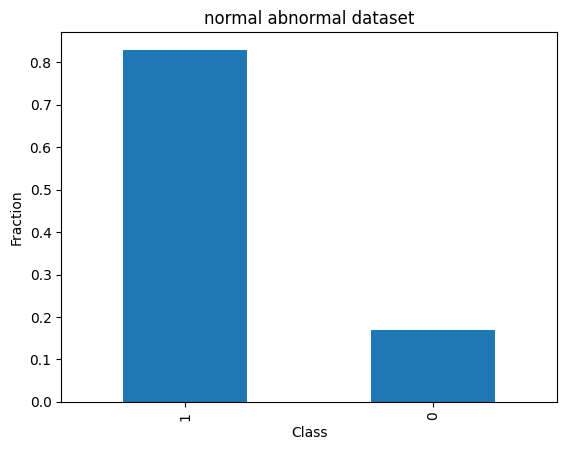

In [6]:
print("class labels values count for normal_abnormal dataset")
print(0, ' - normal')
print(1, ' - abnormal')
print(df_normal_abnormal['true_label_num'].value_counts(normalize=True))

df_normal_abnormal['true_label_num'].value_counts(normalize=True).plot(kind='bar', title='normal abnormal dataset',xlabel='Class', ylabel='Fraction')

plt.show()

class labels values count for benign_malign dataset
0  - benign
1  - malign
true_label_num
0    0.675926
1    0.324074
Name: proportion, dtype: float64


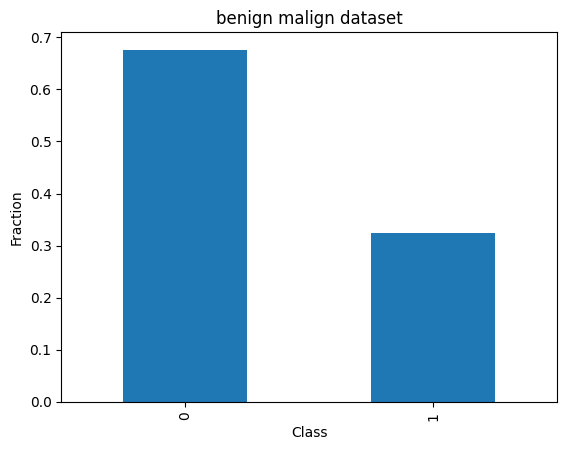

In [7]:
print("class labels values count for benign_malign dataset")
print(0, ' - benign')
print(1, ' - malign')
print(df_abnormal['true_label_num'].value_counts(normalize=True))

df_abnormal['true_label_num'].value_counts(normalize=True).plot(kind='bar', title='benign malign dataset',xlabel='Class', ylabel='Fraction')

plt.show()

# normal abnormal classification using 1 neuron

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet34 = models.resnet34(weights='ResNet34_Weights.DEFAULT')

model_norm_abnorm = torch.nn.Sequential(
    resnet34,
    torch.nn.ReLU(),
    torch.nn.Dropout(0.7),
    torch.nn.Linear(1000, 1)
)


# move model to device
model_norm_abnorm = model_norm_abnorm.to(DEVICE)

MODEL_SAVE_DIR = 'ResNet34_norm_abnorm'

# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.3])).to(DEVICE)
#criterion = FocalLoss(alpha=1, gamma=2, logits=True, reduce=True)

optimizer = torch.optim.Adam(
            [{'params': model_norm_abnorm[0].parameters(),'lr': 9e-5},
             {'params': model_norm_abnorm[3].parameters(),'lr': 9e-4}],weight_decay=0.5)

trainer = ClassificationTrainer1(
    model=model_norm_abnorm, epochs=20, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader_normal_abnormal, val_dataloader=val_dataloader_normal_abnormal,
    model_save_dir=MODEL_SAVE_DIR, use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 0.28105130791664124 Train Accuracy: 0.7083333134651184, Val Loss: 0.3223434388637543, Val Accuracy: 0.8280254777070064
Epoch 1 Train Loss: 0.14809708297252655 Train Accuracy: 0.8557692170143127, Val Loss: 0.21315984427928925, Val Accuracy: 0.89171974522293
Epoch 2 Train Loss: 0.0814589411020279 Train Accuracy: 0.9407051205635071, Val Loss: 0.14881978929042816, Val Accuracy: 0.9044585987261147
Epoch 3 Train Loss: 0.05766355246305466 Train Accuracy: 0.942307710647583, Val Loss: 0.18169523775577545, Val Accuracy: 0.89171974522293
Epoch 4 Train Loss: 0.09558617323637009 Train Accuracy: 0.9198718070983887, Val Loss: 0.32635417580604553, Val Accuracy: 0.8853503184713376
Epoch 5 Train Loss: 0.10479863733053207 Train Accuracy: 0.9214743375778198, Val Loss: 0.14330574870109558, Val Accuracy: 0.910828025477707
Epoch 6 Train Loss: 0.06719210743904114 Train Accuracy: 0.942307710647583, Val Loss: 0.11330817639827728, Val Accuracy: 0.9044585987261147
Epoch 7 Train Loss: 0.0400820

In [96]:
# load the best model
best_model = torch.load(os.path.join(MODEL_SAVE_DIR,'model_best.pt'))

In [97]:
#print classification report
#import classification report
from sklearn.metrics import classification_report

# put model in eval mode
best_model.eval()
best_model.to(DEVICE)

# keep list of true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for i, (img, label) in enumerate(val_dataloader_normal_abnormal):
        # send image to device
        img = img.to(DEVICE)    # [batch_size, 3, 256, 256]
        label = label.to(DEVICE)   # [batch_size,]

        # forward pass
        output = best_model(img)    # [batch_size, 1]

        # y_true
        y_true.extend(label.cpu().numpy().tolist())

        # y_pred
        y_pred.extend(torch.where(output>=0,1,0).detach().cpu().numpy())

        
print('Classification Report')
print(classification_report(y_true, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.98      0.96      0.97       128

    accuracy                           0.95       157
   macro avg       0.91      0.93      0.92       157
weighted avg       0.95      0.95      0.95       157



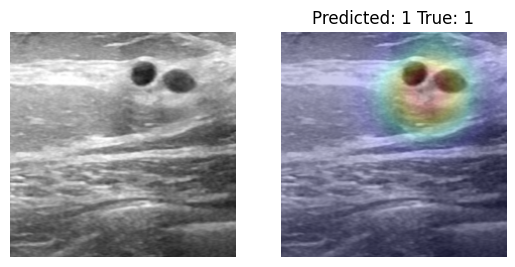

In [98]:
from torchcam.methods import GradCAM
transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
        # Normalize the image using the mean and standard deviation of the ImageNet dataset
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transforms_og = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    ])
np.random.seed(555)
val_dataset_og = UltrasoundDataset(val_df_normal_abnormal, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
val_dataloader_og = DataLoader(val_dataset_og, batch_size=1, shuffle=True)
train_dataset_og = UltrasoundDataset(train_df_normal_abnormal, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
train_dataloader_og = DataLoader(train_dataset_og, batch_size=1, shuffle=True)
best_model.eval()    

i=0
with GradCAM(best_model) as cam_extractor:
    for img, label,og_img, img_path in val_dataloader_og:
        i+=1
        img = img[:1].to(DEVICE)
        label = label.to(DEVICE)
        out = best_model(img)
        activation_map = cam_extractor(0, out)
        # plot activation map
        # plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.show() 
        
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(og_img[0].permute(1, 2, 0).cpu().numpy())
        ax[0].axis('off') 

        result = overlay_mask(to_pil_image(og_img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)
        ax[1].imshow(result)
        ax[1].axis('off')

        plt.title(f'Predicted: {1 if out>=0 else 0} True: {label.item()}')
            
        plt.show()
        if i==1:
            break

In [109]:
#generate mask bounding box around the mask leave some margin
#also generate center point of the mask
import cv2

def mask_bounding_box(mask,margin=5):
    '''
    mask: numpy array of the mask
    margin: margin around the bounding box
    '''
    #convert to grayscale if not
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif len(mask.shape) == 2:
        gray = mask
    else:
        raise ValueError("Unsupported image format")
    
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #get bounding box
    largest_contour=max(contours,key=cv2.contourArea)

    x,y,w,h=cv2.boundingRect(largest_contour)
    #where x,y are the top left corner of the bounding box

    #add margin to the bounding box
    x_min=x-margin if x-margin > 0 else 0
    y_min=y-margin if y-margin > 0 else 0
    x_max=x+w+margin if x+w+margin < mask.shape[1] else mask.shape[1]
    y_max=y+h+margin if y+h+margin < mask.shape[0] else mask.shape[0]
    #get center point
    center_x=x+w//2
    center_y=y+h//2
    return x_min,y_min,x_max,y_max,center_x,center_y


actual label: 1 predicted label: 1


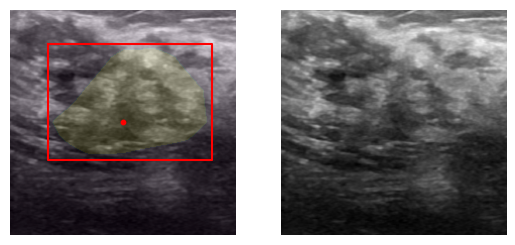

actual label: 1 predicted label: 1


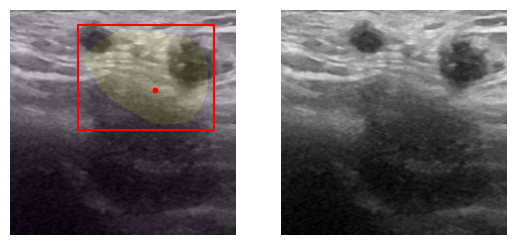

actual label: 1 predicted label: 0


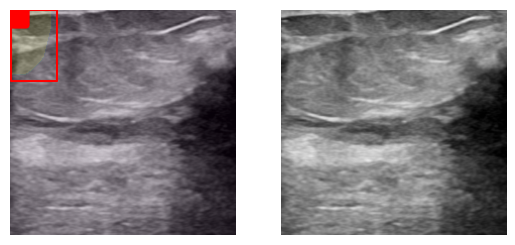

actual label: 1 predicted label: 1


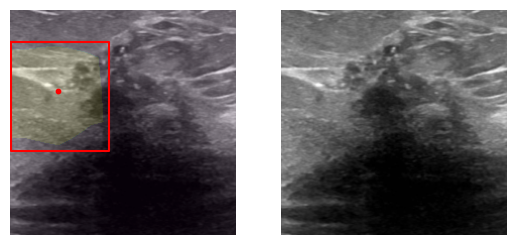

Error in mask bounding box
Error in mask bounding box


df_prompt:                         image  x_min  y_min  x_max  y_max  center_x  center_y  \
0     malignant (51)_mask.png     97     66    525    290       294       216   
1     malignant (44)_mask.png    228     38    689    308       491       204   
2    malignant (194)_mask.png      0      0    189    173         0         0   
3     malignant (97)_mask.png      0     69    255    303       122       173   
4    malignant (143)_mask.png     62    150    459    466       281       233   
..                        ...    ...    ...    ...    ...       ...       ...   
150     benign (170)_mask.png    304     45    564    294       440       167   
151     benign (231)_mask.png     70    162    348    358       197       236   
152     benign (399)_mask.png      0      0    168    190         0        98   
153      benign (25)_mask.png    330      0    666    281       495       124   
154      normal (22)_mask.png    441    398    552    470       512       436   

                

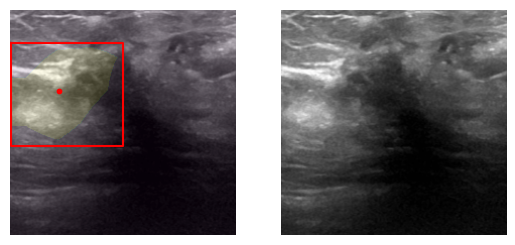

actual label: 1 predicted label: 1


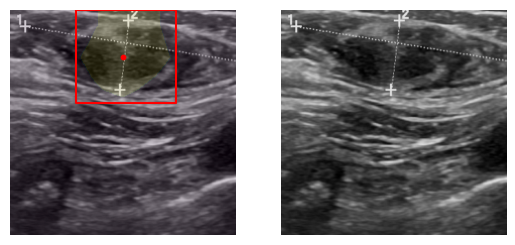

actual label: 1 predicted label: 1


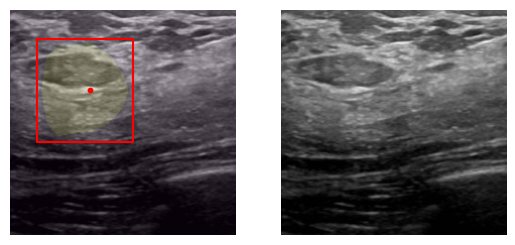

actual label: 1 predicted label: 1


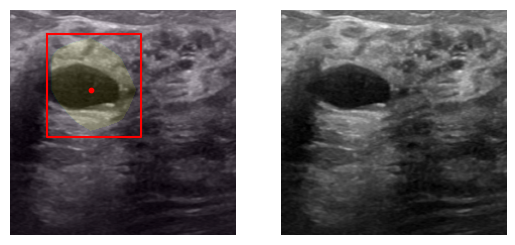

Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
df_prompt:                        image  x_min  y_min  x_max  y_max  center_x  center_y  \
0    malignant (91)_mask.png      0     72    275    297       117       176   
1      benign (218)_mask.png    174      0    440    162       301        83   
2      benign (418)_mask.png     70     53    330    242       214       146   
3      benign (149)_mask.png     89     50    323    263       198       165   
4       benign (73)_ma

In [111]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


def get_prompt_from_cam(best_model, df, SEED, box_margin=5, csv_name=None,max_cam_location=False):

   df_prompt=pd.DataFrame(columns=['image','x_min','y_min','x_max','y_max','center_x','center_y','path','true_label','predicted_label'])

   DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   # create folder PromptSAM if it does not exist
   if not os.path.exists('PromptSAM'):
       os.makedirs( 'PromptSAM')

   torch.manual_seed(SEED)
   np.random.seed(SEED)
   transforms = torchvision.transforms.Compose([
       torchvision.transforms.Resize(256),
       torchvision.transforms.CenterCrop(224),
       torchvision.transforms.ToTensor(),
       #grayscale to RGB since the model was trained on RGB images
       Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
       # Normalize the image using the mean and standard deviation of the ImageNet dataset
       torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   ])

   transforms_og = torchvision.transforms.Compose([
       torchvision.transforms.Resize(256),
       torchvision.transforms.CenterCrop(224),
       torchvision.transforms.ToTensor(),
       #grayscale to RGB since the model was trained on RGB images
       Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
   ])

   dataset_og = UltrasoundDataset(df, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
   dataloader_og = DataLoader(dataset_og, batch_size=1, shuffle=False)


   best_model.eval()    
   
   i=0
   with GradCAM(best_model) as cam_extractor:
       for img, label,og_img, img_path in dataloader_og:
           i+=1
           img = img[:1].to(DEVICE)
           label = label.to(DEVICE)
           out = best_model(img)

           activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
           #plot activation map
           #plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.show() 
           
           #fig,ax = plt.subplots(1,2)
           #plt.imshow(img[0].permute(1, 2, 0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
           #result = overlay_mask(to_pil_image(og_img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
           #result=overlay_mask(to_pil_image(og_img[0]), to_pil_image(torch.stack(activation_map).reshape(7,7), mode='F'), alpha=0.7)
           # #Display it
           #ax[0].imshow(result); ax[0].axis('off'); 
           #ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off'); plt.show()
           
           #thresholding the activation map to get the mask
           threshold = 0.6
           activation_map= torch.stack(activation_map)
           #print('activation map shape:',activation_map.shape)
           activation_map = torch.nn.functional.interpolate(activation_map, size=(224,224), mode='bilinear', align_corners=False)
           
           #location of maximum value in the activation map
           
           x_loc,y_loc=np.where(activation_map[0].squeeze(0).cpu().numpy() == activation_map[0].squeeze(0).cpu().numpy().max())
           
           
           
           #thresholding
           mask = np.where(activation_map[0].squeeze(0).cpu().numpy() > threshold, 1, 0)
           mask=mask.astype(np.uint8)

           mask_3d = np.stack([mask]*3,axis=-1)

           try:
                x_min,y_min,x_max,y_max,center_x,center_y=mask_bounding_box(mask_3d,margin=box_margin)
           except:
                print('Error in mask bounding box')
                continue
           # Display 
           if i < 5:
               print('actual label:',label[0].item(),'predicted label:',1 if out>=0 else 0)
               fig,ax = plt.subplots(1,2)
               ax[0].imshow(og_img[0].permute(1, 2, 0).cpu().numpy())
               ax[0].imshow(mask,alpha=0.1); ax[0].axis('off')
               #show point of maximum value in the mask
               ax[0].scatter(y_loc,x_loc, c='r', s=10)
               #plot bounding box
               ax[0].plot([x_min,x_max,x_max,x_min,x_min],[y_min,y_min,y_max,y_max,y_min],'r')
               ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off')
               plt.show()

        #    # Display 
        #    if i < 50:
        #        print('actual label:',label[0].item(),'predicted label:',1 if out>=0 else 0)
        #        fig,ax = plt.subplots(1,2)
        #        ax[0].imshow(mask); ax[0].axis('off')
        #        #show point of maximum value in the mask
        #        ax[0].scatter(y_loc,x_loc, c='r', s=10)
        #        #plot bounding box
        #        ax[0].plot([x_min,x_max,x_max,x_min,x_min],[y_min,y_min,y_max,y_max,y_min],'r')
               
        #        ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off'); plt.show()
               
          ### 
           #take the product of the mask and the image
           #print shape of mask and image

           cropped_img = og_img[0].permute(1, 2, 0).cpu().numpy() * mask[:,:,None]

           # Display it
           #print(cropped_img.shape)

           #plt.imshow(cropped_img); plt.axis('off'); plt.show()

           #generate mask bounding box around the mask leave some margin
           
           predicted_label = out.argmax().item()

               

           #also generate center point of the mask
           
           
           #replace center_x and center_y with the location of maximum value in the activation map
           if max_cam_location:
               center_x=y_loc[0]
               center_y=x_loc[0]
           
           
           
           #now we wamt to traslate the bounding box to the original image
           #get the original image using the path
           img_path=img_path[0]
           img_path=fix_sep(img_path)
           
           img_name=img_path.split(os.sep)[-1]
           img_name=img_name.split('.')[0]
           img_name=img_name+'_mask.png'
           
           #true label
           true_label=label[0].item()
           predicted_label= 1 if out>=0 else 0
         
           # print('img_path:',img_path)
           original_img=cv2.imread(img_path)
           
           #get the original image shape
           original_img_shape=original_img.shape
           
           #get the scaling factor
           scale_x=original_img_shape[1]/224
           scale_y=original_img_shape[0]/224
           
           #scale the bounding box
           x_min=int(x_min*scale_x)
           y_min=int(y_min*scale_y)
           x_max=int(x_max*scale_x)
           y_max=int(y_max*scale_y)
           center_x=int(center_x*scale_x)
           center_y=int(center_y*scale_y)
           
           # #draw bounding box on the original image
           # bbox_point_img= original_img.copy()
   

           # #draw bounding box on the cropped image
           # bbox_point_img= cropped_img.copy()
           # cv2.rectangle(bbox_point_img,(x_min,y_min),(x_max,y_max),(0,255,0),2)
           # #draw center point
           # cv2.circle(bbox_point_img,(center_x,center_y),5,(0,0,255),-1)

           #show mask with bounding box and center point
           #plt.imshow(bbox_point_img); plt.axis('off'); plt.show()

           #get the image name
           

           
           #store the bounding box and center point in the dataframe in format image,x_min,y_min,x_max,y_max,center_x,center_y,path,true_label,predicted_label
           df_prompt.loc[len(df_prompt)] = [img_name,x_min,y_min,x_max,y_max,center_x,center_y,img_path,true_label+1,predicted_label+1]

   print('df_prompt:',df_prompt)
   #sort the dataframe by img_name
   df_prompt=df_prompt.sort_values(by='image')
   #save df_prompt to csv
   csv_path=os.path.join('PromptSAM',csv_name)
   df_prompt.to_csv(csv_path,index=False)
   print('Prompt saved to:',csv_path)


get_prompt_from_cam(best_model, val_df_normal_abnormal, SEED, box_margin=5, csv_name='prompt_valid_normal_abnormal_maxon.csv',max_cam_location=True)
get_prompt_from_cam(best_model, train_df_normal_abnormal, SEED, box_margin=5, csv_name='prompt_train_normal_abnormal_maxon.csv',max_cam_location=True)


# with 1 neuron at op

In [84]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet34 = models.resnet34(weights='ResNet34_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet34,
    torch.nn.ReLU(),
    torch.nn.Dropout(0.7),
    torch.nn.Linear(1000, 1)
)


# move model to device
model = model.to(DEVICE)

MODEL_SAVE_DIR = 'ResNet34'

# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1/0.33])).to(DEVICE)
#criterion = FocalLoss(alpha=1, gamma=2, logits=True, reduce=True)

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
             {'params': model[3].parameters(),'lr': 9e-4}],weight_decay=0.5)

trainer = ClassificationTrainer(
    model=model, epochs=20, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader_abnormal, val_dataloader=val_dataloader_abnormal,
    model_save_dir=MODEL_SAVE_DIR, use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 1.1746976375579834 Train Accuracy: 0.5656566023826599, Val Loss: 1.180961012840271, Val Accuracy: 0.46923076923076923
Epoch 1 Train Loss: 0.5183057188987732 Train Accuracy: 0.8371211886405945, Val Loss: 0.5946667194366455, Val Accuracy: 0.8307692307692308
Epoch 2 Train Loss: 0.3841139078140259 Train Accuracy: 0.8787878751754761, Val Loss: 0.6751900911331177, Val Accuracy: 0.7923076923076923
Epoch 3 Train Loss: 0.25545430183410645 Train Accuracy: 0.9494949579238892, Val Loss: 1.5968791246414185, Val Accuracy: 0.8307692307692308
Epoch 4 Train Loss: 0.25359228253364563 Train Accuracy: 0.9337121248245239, Val Loss: 1.0073354244232178, Val Accuracy: 0.8692307692307693
Epoch 5 Train Loss: 0.37487098574638367 Train Accuracy: 0.9223484992980957, Val Loss: 0.5423346161842346, Val Accuracy: 0.8846153846153846
Epoch 6 Train Loss: 0.3038133382797241 Train Accuracy: 0.9305555820465088, Val Loss: 0.48170068860054016, Val Accuracy: 0.8846153846153846
Epoch 7 Train Loss: 0.27380633

In [85]:
# load the best model
best_model = torch.load(os.path.join(MODEL_SAVE_DIR,'model_best.pt'))

In [86]:
#print classification report
#import classification report
from sklearn.metrics import classification_report

# put model in eval mode
best_model.eval()
best_model.to(DEVICE)

# keep list of true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for i, (img, label) in enumerate(val_dataloader_abnormal):
        # send image to device
        img = img.to(DEVICE)    # [batch_size, 3, 256, 256]
        label = label.to(DEVICE)   # [batch_size,]

        # forward pass
        output = best_model(img)    # [batch_size, 1]

        # y_true
        y_true.extend(label.cpu().numpy().tolist())

        # y_pred
        y_pred.extend(torch.where(output>=0,1,0).detach().cpu().numpy())

        
print('Classification Report')
print(classification_report(y_true, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        90
           1       0.83      0.95      0.88        40

    accuracy                           0.92       130
   macro avg       0.90      0.93      0.91       130
weighted avg       0.93      0.92      0.92       130



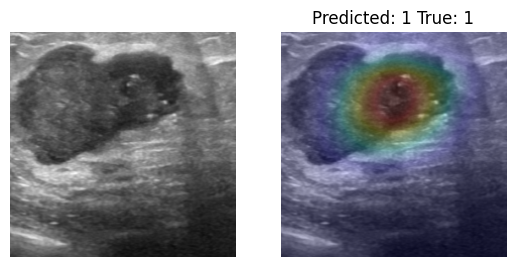

In [172]:
from torchcam.methods import GradCAM
transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
        # Normalize the image using the mean and standard deviation of the ImageNet dataset
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transforms_og = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    ])
np.random.seed(555)
val_dataset_og = UltrasoundDataset(val_df_abnormal, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
val_dataloader_og = DataLoader(val_dataset_og, batch_size=1, shuffle=True)
train_dataset_og = UltrasoundDataset(train_df_abnormal, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
train_dataloader_og = DataLoader(train_dataset_og, batch_size=1, shuffle=True)
best_model.eval()    

i=0
with GradCAM(best_model) as cam_extractor:
    for img, label,og_img, img_path in val_dataloader_og:
        i+=1
        img = img[:1].to(DEVICE)
        label = label.to(DEVICE)
        out = best_model(img)
        activation_map = cam_extractor(0, out)
        # plot activation map
        # plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.show() 
        
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(og_img[0].permute(1, 2, 0).cpu().numpy())
        ax[0].axis('off') 

        result = overlay_mask(to_pil_image(og_img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)
        ax[1].imshow(result)
        ax[1].axis('off')

        plt.title(f'Predicted: {1 if out>=0 else 0} True: {label.item()}')
            
        plt.show()
        if i==1:
            break

In [175]:
#generate mask bounding box around the mask leave some margin
#also generate center point of the mask
import cv2

def mask_bounding_box(mask,margin=5):
    '''
    mask: numpy array of the mask
    margin: margin around the bounding box
    '''
    #convert to grayscale if not
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif len(mask.shape) == 2:
        gray = mask
    else:
        raise ValueError("Unsupported image format")
    
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #get bounding box
    largest_contour=max(contours,key=cv2.contourArea)

    x,y,w,h=cv2.boundingRect(largest_contour)
    #where x,y are the top left corner of the bounding box

    #add margin to the bounding box
    x_min=x-margin if x-margin > 0 else 0
    y_min=y-margin if y-margin > 0 else 0
    x_max=x+w+margin if x+w+margin < mask.shape[1] else mask.shape[1]
    y_max=y+h+margin if y+h+margin < mask.shape[0] else mask.shape[0]
    #get center point
    center_x=x+w//2
    center_y=y+h//2
    return x_min,y_min,x_max,y_max,center_x,center_y


actual label: 0 predicted label: 0


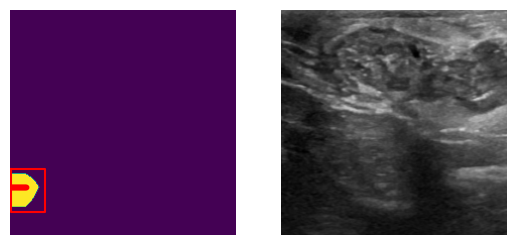

actual label: 0 predicted label: 0


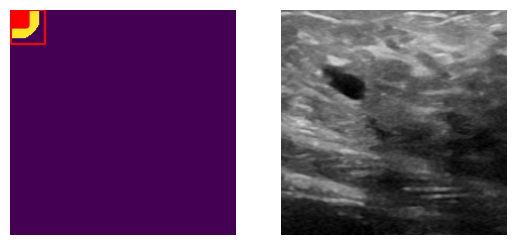

Error in mask bounding box
actual label: 0 predicted label: 0


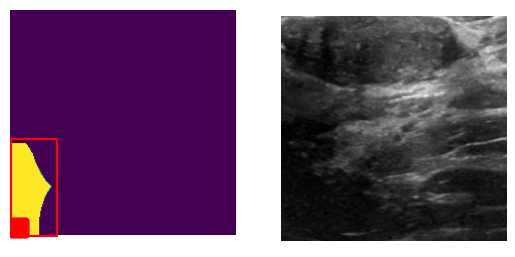

Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
E

In [180]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


def get_prompt_from_cam(best_model, df, SEED, box_margin=5, csv_name=None,max_cam_location=False):

   df_prompt=pd.DataFrame(columns=['image','x_min','y_min','x_max','y_max','center_x','center_y','path','true_label','predicted_label'])

   DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   # create folder PromptSAM if it does not exist
   if not os.path.exists('PromptSAM'):
       os.makedirs( 'PromptSAM')

   torch.manual_seed(SEED)
   np.random.seed(SEED)
   transforms = torchvision.transforms.Compose([
       torchvision.transforms.Resize(256),
       torchvision.transforms.CenterCrop(224),
       torchvision.transforms.ToTensor(),
       #grayscale to RGB since the model was trained on RGB images
       Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
       # Normalize the image using the mean and standard deviation of the ImageNet dataset
       torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   ])

   transforms_og = torchvision.transforms.Compose([
       torchvision.transforms.Resize(256),
       torchvision.transforms.CenterCrop(224),
       torchvision.transforms.ToTensor(),
       #grayscale to RGB since the model was trained on RGB images
       Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
   ])

   dataset_og = UltrasoundDataset(df, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
   dataloader_og = DataLoader(dataset_og, batch_size=1, shuffle=False)


   best_model.eval()    
   
   i=0
   with GradCAM(best_model) as cam_extractor:
       for img, label,og_img, img_path in dataloader_og:
           i+=1
           img = img[:1].to(DEVICE)
           label = label.to(DEVICE)
           out = best_model(img)

           activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
           #plot activation map
           #plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.show() 
           
           #fig,ax = plt.subplots(1,2)
           #plt.imshow(img[0].permute(1, 2, 0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
           #result = overlay_mask(to_pil_image(og_img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
           #result=overlay_mask(to_pil_image(og_img[0]), to_pil_image(torch.stack(activation_map).reshape(7,7), mode='F'), alpha=0.7)
           # #Display it
           #ax[0].imshow(result); ax[0].axis('off'); 
           #ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off'); plt.show()
           
           #thresholding the activation map to get the mask
           threshold = 0.6
           activation_map= torch.stack(activation_map)
           #print('activation map shape:',activation_map.shape)
           activation_map = torch.nn.functional.interpolate(activation_map, size=(224,224), mode='bilinear', align_corners=False)
           
           #location of maximum value in the activation map
           
           x_loc,y_loc=np.where(activation_map[0].squeeze(0).cpu().numpy() == activation_map[0].squeeze(0).cpu().numpy().max())
           
           
           
           #thresholding
           mask = np.where(activation_map[0].squeeze(0).cpu().numpy() > threshold, 1, 0)
           mask=mask.astype(np.uint8)

           mask_3d = np.stack([mask]*3,axis=-1)

           try:
                x_min,y_min,x_max,y_max,center_x,center_y=mask_bounding_box(mask_3d,margin=box_margin)
           except:
                print('Error in mask bounding box')
                continue
           

           # Display 
           if i < 5:
               print('actual label:',label[0].item(),'predicted label:',1 if out>=0 else 0)
               fig,ax = plt.subplots(1,2)
               ax[0].imshow(mask); ax[0].axis('off')
               #show point of maximum value in the mask
               ax[0].scatter(y_loc,x_loc, c='r', s=10)
               #plot bounding box
               ax[0].plot([x_min,x_max,x_max,x_min,x_min],[y_min,y_min,y_max,y_max,y_min],'r')
               
               ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off'); plt.show()
               
           
           #take the product of the mask and the image
           #print shape of mask and image

           cropped_img = og_img[0].permute(1, 2, 0).cpu().numpy() * mask[:,:,None]

           # Display it
           #print(cropped_img.shape)

           #plt.imshow(cropped_img); plt.axis('off'); plt.show()

           #generate mask bounding box around the mask leave some margin
           
           predicted_label = out.argmax().item()

               

           #also generate center point of the mask
           
           
           #replace center_x and center_y with the location of maximum value in the activation map
           if max_cam_location:
               center_x=y_loc[0]
               center_y=x_loc[0]
           
           
           
           #now we wamt to traslate the bounding box to the original image
           #get the original image using the path
           img_path=img_path[0]
           img_path=fix_sep(img_path)
           
           img_name=img_path.split(os.sep)[-1]
           img_name=img_name.split('.')[0]
           img_name=img_name+'_mask.png'
           
           #true label
           true_label=label[0].item()
           predicted_label= 1 if out>=0 else 0
         
           # print('img_path:',img_path)
           original_img=cv2.imread(img_path)
           
           #get the original image shape
           original_img_shape=original_img.shape
           
           #get the scaling factor
           scale_x=original_img_shape[1]/224
           scale_y=original_img_shape[0]/224
           
           #scale the bounding box
           x_min=int(x_min*scale_x)
           y_min=int(y_min*scale_y)
           x_max=int(x_max*scale_x)
           y_max=int(y_max*scale_y)
           center_x=int(center_x*scale_x)
           center_y=int(center_y*scale_y)
           
           # #draw bounding box on the original image
           # bbox_point_img= original_img.copy()
   

           # #draw bounding box on the cropped image
           # bbox_point_img= cropped_img.copy()
           # cv2.rectangle(bbox_point_img,(x_min,y_min),(x_max,y_max),(0,255,0),2)
           # #draw center point
           # cv2.circle(bbox_point_img,(center_x,center_y),5,(0,0,255),-1)

           #show mask with bounding box and center point
           #plt.imshow(bbox_point_img); plt.axis('off'); plt.show()

           #get the image name
           

           
           #store the bounding box and center point in the dataframe in format image,x_min,y_min,x_max,y_max,center_x,center_y,path,true_label,predicted_label
           df_prompt.loc[len(df_prompt)] = [img_name,x_min,y_min,x_max,y_max,center_x,center_y,img_path,true_label+1,predicted_label+1]

   print('df_prompt:',df_prompt)
   #sort the dataframe by img_name
   df_prompt=df_prompt.sort_values(by='image')
   #save df_prompt to csv
   csv_path=os.path.join('PromptSAM',csv_name)
   df_prompt.to_csv(csv_path,index=False)
   print('Prompt saved to:',csv_path)


get_prompt_from_cam(model, val_df_abnormal, SEED, box_margin=5, csv_name='prompt_valid.csv')
get_prompt_from_cam(model, train_df_abnormal, SEED, box_margin=5, csv_name='prompt_train.csv')


# with 2 neuron at op

In [52]:
class ClassificationTrainer:
    def __init__(self, model,epochs, criterion, optimizer,
                 train_dataloader,val_dataloader,model_save_dir,save_best_del_rest=True,use_scheduler=False, displ_print=True, pbar_visible=False):
        # attributes
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.epochs = epochs
        self.val_data_loader = val_dataloader
        self.model_save_dir = model_save_dir
        self.save_best_del_rest = save_best_del_rest      # model saved after each epoch and deleted if not the best
        self.use_scheduler = use_scheduler
        self.displ_print = displ_print
        self.pbar_visible = pbar_visible


        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if use_scheduler:
            self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # send model to device
        self.model.to(self.device)

        # check if model directory exits, otherwise create one
        if not os.path.exists(self.model_save_dir):
            os.makedirs(self.model_save_dir)

        if self.save_best_del_rest:
            self.metrics = {'train_loss':{}, 'train_acc':{}, 'val_loss':{}, 'val_acc':{}}

    def train(self):
        # put model in train mode
        self.model.train()

        with tqdm(range(self.epochs),disable=not self.pbar_visible) as pbar:
            for epoch in pbar:
                # running sum of loss and accuracy
                loss_list = []
                acc_list = []
                for i, (img, label) in enumerate(self.train_dataloader):
                    # set gradient to zero
                    self.optimizer.zero_grad()

                    # send to device
                    img = img.to(self.device)       # [batch_size, 3, 256, 256]
                    label = label.to(self.device)   # [batch_size,]

                    # forward pass
                    output = self.model(img)        # output: [batch_size, 2]
                    
                    loss = self.criterion(output, label)

                    # backward pass
                    loss.backward()

                    self.optimizer.step()

                    # calculate and add 
                    acc = accuracy_score(label.detach().cpu().numpy(),
                                          torch.argmax(torch.softmax(output,dim=-1),dim=-1).detach().cpu().numpy())
                    
                    # append loss and accuracy
                    loss_list.append(loss.item())
                    acc_list.append(acc)
                
                # calculate validation loss and accuracy
                val_loss, val_acc = self.validate()

                # calculate train loss and accuracy
                loss_list = torch.tensor(loss_list)
                acc_list = torch.tensor(acc_list)
                train_loss = torch.mean(loss_list)
                train_acc = torch.mean(acc_list)

                # take schedular step
                if self.use_scheduler:
                    self.lr_scheduler.step()

                if self.displ_print:
                    print(f'Epoch {epoch} Train Loss: {train_loss} Train Accuracy: {train_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}')
                pbar.set_description(f'Train Loss: {train_loss}, Val Loss: {val_loss}')
                pbar.update(1)

                # save metrics
                if self.save_best_del_rest:
                    self.metrics['train_loss'][epoch] = train_loss.item()
                    self.metrics['train_acc'][epoch] = train_acc.item()
                    self.metrics['val_loss'][epoch] = val_loss.item()
                    self.metrics['val_acc'][epoch] = val_acc
                    torch.save(self.model, os.path.join(self.model_save_dir, f'model_{epoch}.pt'))

        # save model
        if self.save_best_del_rest:
            self.keep_best_delete_rest()
        else:
            torch.save(self.model, os.path.join(self.model_save_dir, 'model_last_ep.pt'))
            with open(os.path.join(self.model_save_dir, 'metrics_saved_model.json'), 'w') as f:
                metrics = {'train_loss':train_loss.item(), 'train_acc': train_acc.item(), 'val_loss': val_loss.item(), 'val_acc': val_acc}
                json.dump(metrics, f,indent=2)

    
    def validate(self):

        # put model in eval mode
        self.model.eval()

        # keep list of true and predicted labels
        y_true = []
        y_pred = []
        loss_list = []

        with torch.no_grad():
            for i, (img, label) in enumerate(self.val_data_loader):
                # send image to device
                img = img.to(self.device)    # [batch_size, 3, 256, 256]
                label = label.to(self.device)   # [batch_size,]
                # label = torch.nn.functional.one_hot(label, num_classes=2).float()

                # forward pass
                output = self.model(img)    # [batch_size, 1]

                # y_true
                y_true.extend(label.cpu().numpy().tolist())

                # y_pred
                y_pred.extend(torch.argmax(output,dim=-1).detach().cpu().numpy())

                # calculate loss
                loss_ = self.criterion(output, label).item()

                loss_list.append(loss_)

        # calculate loss
        loss_list = torch.tensor(loss_list)
        loss = torch.mean(loss_list)

        # calculate accuracy
        acc = accuracy_score(y_true, y_pred)

        # put model back in train mode
        self.model.train()

        return loss, acc 
    
    def keep_best_delete_rest(self):
        # sort the models based on validation accuracy
        best_val_acc_epoch = max(self.metrics['val_acc'], key=self.metrics['val_acc'].get)

        # best model path
        best_model_path = os.path.join(self.model_save_dir, f'model_{best_val_acc_epoch}.pt')

        for model_path in os.listdir(self.model_save_dir):
            if model_path != f'model_{best_val_acc_epoch}.pt':
                os.remove(os.path.join(self.model_save_dir, model_path))
        
        # rename the best model
        os.rename(best_model_path, os.path.join(self.model_save_dir, 'model_best.pt'))

        # save metrics
        with open(os.path.join(self.model_save_dir, 'metrics.json'), 'w') as f:
            json.dump(self.metrics, f,indent=2)
        
        with open(os.path.join(self.model_save_dir, 'metrics_saved_model.json'), 'w') as f:
                metrics = {'train_loss':self.metrics['train_loss'][best_val_acc_epoch],
                            'train_acc': self.metrics['train_acc'][best_val_acc_epoch],
                            'val_loss': self.metrics['val_loss'][best_val_acc_epoch],
                            'val_acc': self.metrics['val_acc'][best_val_acc_epoch]}
                json.dump(metrics, f,indent=2)
         

In [83]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet34 = models.resnet34(weights='ResNet34_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet34,
    torch.nn.ReLU(),
    torch.nn.Dropout(0.7),
    torch.nn.Linear(1000, 2)
)


# move model to device
model = model.to(DEVICE)

MODEL_SAVE_DIR = 'ResNet34_2class'

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1/0.67,2/0.33])).to(DEVICE)
#criterion = FocalLoss(alpha=1, gamma=2, logits=True, reduce=True)

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
             {'params': model[3].parameters(),'lr': 9e-4}],weight_decay=0.5)

trainer = ClassificationTrainer(
    model=model, epochs=20, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader_abnormal, val_dataloader=val_dataloader_abnormal,
    model_save_dir=MODEL_SAVE_DIR, use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 0.7609351277351379 Train Accuracy: 0.6130051016807556, Val Loss: 0.6276203393936157, Val Accuracy: 0.823076923076923
Epoch 1 Train Loss: 0.5024312734603882 Train Accuracy: 0.7544191479682922, Val Loss: 0.354082852602005, Val Accuracy: 0.7461538461538462
Epoch 2 Train Loss: 0.232292041182518 Train Accuracy: 0.8674242496490479, Val Loss: 0.5280557870864868, Val Accuracy: 0.8692307692307693
Epoch 3 Train Loss: 0.18689283728599548 Train Accuracy: 0.9172980189323425, Val Loss: 0.3305879831314087, Val Accuracy: 0.8846153846153846
Epoch 4 Train Loss: 0.2087915539741516 Train Accuracy: 0.9242424368858337, Val Loss: 0.5177655816078186, Val Accuracy: 0.8384615384615385
Epoch 5 Train Loss: 0.3280242085456848 Train Accuracy: 0.8497474789619446, Val Loss: 0.43813836574554443, Val Accuracy: 0.8307692307692308
Epoch 6 Train Loss: 0.26213178038597107 Train Accuracy: 0.8667929172515869, Val Loss: 0.337276816368103, Val Accuracy: 0.8461538461538461
Epoch 7 Train Loss: 0.1696938127279

In [85]:
# load the best model
best_model = torch.load(os.path.join(MODEL_SAVE_DIR,'model_best.pt'))

In [86]:
#print classification report
#import classification report
from sklearn.metrics import classification_report

# put model in eval mode
best_model.eval()
best_model.to(DEVICE)

# keep list of true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for i, (img, label) in enumerate(val_dataloader_abnormal):
        # send image to device
        img = img.to(DEVICE)    # [batch_size, 3, 256, 256]
        label = label.to(DEVICE)   # [batch_size,]

        # forward pass
        output = best_model(img)    # [batch_size, 1]

        # y_true
        y_true.extend(label.cpu().numpy().tolist())

        # y_pred
        y_pred.extend(torch.argmax(output,-1).detach().cpu().numpy())

        
print('Classification Report')
print(classification_report(y_true, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.93      0.94        90
           1       0.85      0.88      0.86        40

    accuracy                           0.92       130
   macro avg       0.90      0.90      0.90       130
weighted avg       0.92      0.92      0.92       130



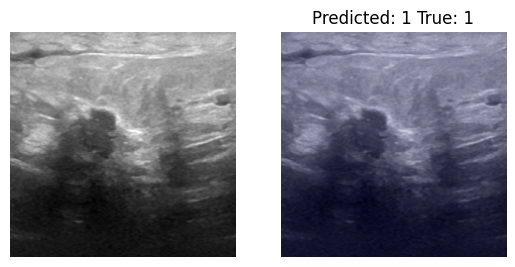

In [106]:
from torchcam.methods import GradCAM
transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
        # Normalize the image using the mean and standard deviation of the ImageNet dataset
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transforms_og = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    ])
np.random.seed(555)
val_dataset_og = UltrasoundDataset(val_df_abnormal, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
val_dataloader_og = DataLoader(val_dataset_og, batch_size=1, shuffle=True)
train_dataset_og = UltrasoundDataset(train_df_abnormal, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
train_dataloader_og = DataLoader(train_dataset_og, batch_size=1, shuffle=True)
best_model.eval()    

i=0
with GradCAM(best_model) as cam_extractor:
    for img, label,og_img, img_path in val_dataloader_og:
        i+=1
        img = img[:1].to(DEVICE)
        label = label.to(DEVICE)
        out = best_model(img)
        activation_map = cam_extractor(0, out)
        # plot activation map
        # plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.show() 
        
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(og_img[0].permute(1, 2, 0).cpu().numpy())
        ax[0].axis('off') 

        result = overlay_mask(to_pil_image(og_img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)
        ax[1].imshow(result)
        ax[1].axis('off')

        plt.title(f'Predicted: {torch.argmax(out,-1).item()} True: {label.item()}')
            
        plt.show()
        if i==1:
            break

In [ ]:
#generate mask bounding box around the mask leave some margin
#also generate center point of the mask
import cv2

def mask_bounding_box(mask,margin=5):
    '''
    mask: numpy array of the mask
    margin: margin around the bounding box
    '''
    #convert to grayscale if not
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif len(mask.shape) == 2:
        gray = mask
    else:
        raise ValueError("Unsupported image format")
    
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #get bounding box
    largest_contour=max(contours,key=cv2.contourArea)

    x,y,w,h=cv2.boundingRect(largest_contour)
    #where x,y are the top left corner of the bounding box

    #add margin to the bounding box
    x_min=x-margin if x-margin > 0 else 0
    y_min=y-margin if y-margin > 0 else 0
    x_max=x+w+margin if x+w+margin < mask.shape[1] else mask.shape[1]
    y_max=y+h+margin if y+h+margin < mask.shape[0] else mask.shape[0]
    #get center point
    center_x=x+w//2
    center_y=y+h//2
    return x_min,y_min,x_max,y_max,center_x,center_y


actual label: 0 predicted label: 0


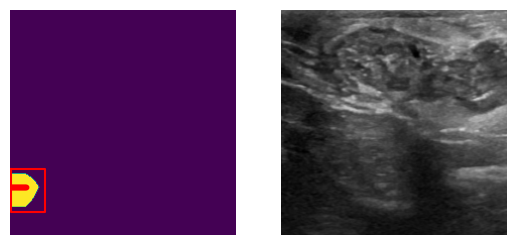

actual label: 0 predicted label: 0


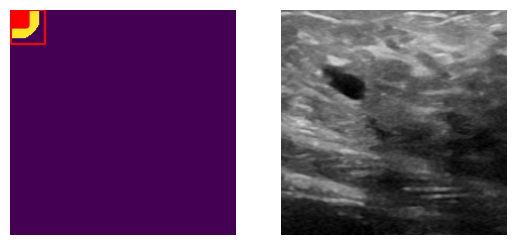

Error in mask bounding box
actual label: 0 predicted label: 0


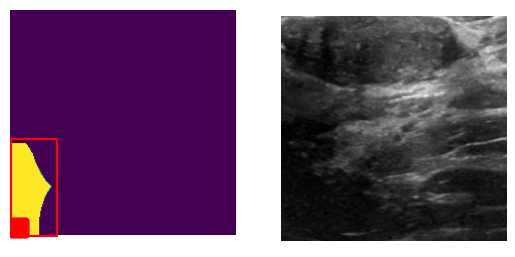

Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
Error in mask bounding box
E

In [ ]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


def get_prompt_from_cam(best_model, df, SEED, box_margin=5, csv_name=None,max_cam_location=False):

   df_prompt=pd.DataFrame(columns=['image','x_min','y_min','x_max','y_max','center_x','center_y','path','true_label','predicted_label'])

   DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   # create folder PromptSAM if it does not exist
   if not os.path.exists('PromptSAM'):
       os.makedirs( 'PromptSAM')

   torch.manual_seed(SEED)
   np.random.seed(SEED)
   transforms = torchvision.transforms.Compose([
       torchvision.transforms.Resize(256),
       torchvision.transforms.CenterCrop(224),
       torchvision.transforms.ToTensor(),
       #grayscale to RGB since the model was trained on RGB images
       Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
       # Normalize the image using the mean and standard deviation of the ImageNet dataset
       torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   ])

   transforms_og = torchvision.transforms.Compose([
       torchvision.transforms.Resize(256),
       torchvision.transforms.CenterCrop(224),
       torchvision.transforms.ToTensor(),
       #grayscale to RGB since the model was trained on RGB images
       Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
   ])

   dataset_og = UltrasoundDataset(df, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
   dataloader_og = DataLoader(dataset_og, batch_size=1, shuffle=False)


   best_model.eval()    
   
   i=0
   with GradCAM(best_model) as cam_extractor:
       for img, label,og_img, img_path in dataloader_og:
           i+=1
           img = img[:1].to(DEVICE)
           label = label.to(DEVICE)
           out = best_model(img)

           activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
           #plot activation map
           #plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.show() 
           
           #fig,ax = plt.subplots(1,2)
           #plt.imshow(img[0].permute(1, 2, 0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
           #result = overlay_mask(to_pil_image(og_img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
           #result=overlay_mask(to_pil_image(og_img[0]), to_pil_image(torch.stack(activation_map).reshape(7,7), mode='F'), alpha=0.7)
           # #Display it
           #ax[0].imshow(result); ax[0].axis('off'); 
           #ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off'); plt.show()
           
           #thresholding the activation map to get the mask
           threshold = 0.6
           activation_map= torch.stack(activation_map)
           #print('activation map shape:',activation_map.shape)
           activation_map = torch.nn.functional.interpolate(activation_map, size=(224,224), mode='bilinear', align_corners=False)
           
           #location of maximum value in the activation map
           
           x_loc,y_loc=np.where(activation_map[0].squeeze(0).cpu().numpy() == activation_map[0].squeeze(0).cpu().numpy().max())
           
           
           
           #thresholding
           mask = np.where(activation_map[0].squeeze(0).cpu().numpy() > threshold, 1, 0)
           mask=mask.astype(np.uint8)

           mask_3d = np.stack([mask]*3,axis=-1)

           try:
                x_min,y_min,x_max,y_max,center_x,center_y=mask_bounding_box(mask_3d,margin=box_margin)
           except:
                print('Error in mask bounding box')
                continue
           

        #    # Display 
        #    if i < 5:
        #        print('actual label:',label[0].item(),'predicted label:',1 if out>=0 else 0)
        #        fig,ax = plt.subplots(1,2)
        #        ax[0].imshow(mask); ax[0].axis('off')
        #        #show point of maximum value in the mask
        #        ax[0].scatter(y_loc,x_loc, c='r', s=10)
        #        #plot bounding box
        #        ax[0].plot([x_min,x_max,x_max,x_min,x_min],[y_min,y_min,y_max,y_max,y_min],'r')
               
        #        ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off'); plt.show()
               
           
           #take the product of the mask and the image
           #print shape of mask and image

           cropped_img = og_img[0].permute(1, 2, 0).cpu().numpy() * mask[:,:,None]

           # Display it
           #print(cropped_img.shape)

           #plt.imshow(cropped_img); plt.axis('off'); plt.show()

           #generate mask bounding box around the mask leave some margin
           
           predicted_label = out.argmax().item()

               

           #also generate center point of the mask
           
           
           #replace center_x and center_y with the location of maximum value in the activation map
           if max_cam_location:
               center_x=y_loc[0]
               center_y=x_loc[0]
           
           
           
           #now we wamt to traslate the bounding box to the original image
           #get the original image using the path
           img_path=img_path[0]
           img_path=fix_sep(img_path)
           
           img_name=img_path.split(os.sep)[-1]
           img_name=img_name.split('.')[0]
           img_name=img_name+'_mask.png'
           
           #true label
           true_label=label[0].item()
           predicted_label= 1 if out>=0 else 0
         
           # print('img_path:',img_path)
           original_img=cv2.imread(img_path)
           
           #get the original image shape
           original_img_shape=original_img.shape
           
           #get the scaling factor
           scale_x=original_img_shape[1]/224
           scale_y=original_img_shape[0]/224
           
           #scale the bounding box
           x_min=int(x_min*scale_x)
           y_min=int(y_min*scale_y)
           x_max=int(x_max*scale_x)
           y_max=int(y_max*scale_y)
           center_x=int(center_x*scale_x)
           center_y=int(center_y*scale_y)
           
           # #draw bounding box on the original image
           # bbox_point_img= original_img.copy()
   

           # #draw bounding box on the cropped image
           # bbox_point_img= cropped_img.copy()
           # cv2.rectangle(bbox_point_img,(x_min,y_min),(x_max,y_max),(0,255,0),2)
           # #draw center point
           # cv2.circle(bbox_point_img,(center_x,center_y),5,(0,0,255),-1)

           #show mask with bounding box and center point
           #plt.imshow(bbox_point_img); plt.axis('off'); plt.show()

           #get the image name
           

           
           #store the bounding box and center point in the dataframe in format image,x_min,y_min,x_max,y_max,center_x,center_y,path,true_label,predicted_label
           df_prompt.loc[len(df_prompt)] = [img_name,x_min,y_min,x_max,y_max,center_x,center_y,img_path,true_label+1,predicted_label+1]

   print('df_prompt:',df_prompt)
   #sort the dataframe by img_name
   df_prompt=df_prompt.sort_values(by='image')
   #save df_prompt to csv
   csv_path=os.path.join('PromptSAM',csv_name)
   df_prompt.to_csv(csv_path,index=False)
   print('Prompt saved to:',csv_path)


get_prompt_from_cam(model, val_df_abnormal, SEED, box_margin=5, csv_name='prompt_valid.csv')
get_prompt_from_cam(model, train_df_abnormal, SEED, box_margin=5, csv_name='prompt_train.csv')
